In [1]:
# display output from every line without explicit print()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
import plotnine as pn

# Introduction to Python for Data Science, Homework 6

YOUR NAME HERE

In Homework 6, you will work with simulated data that is generated in Part 1.

Questions 2–5 will walk through the estimation of ordinary least squares (linear regression) models with this data. 

Question 6 will involve estimation of decision trees.

Question 7 will introduce K-fold cross validation, an widely used approach for selecting the optimal parameters of machine-learning models, using decision trees as a working model. 

Finally, Question 8 will walk through the estimation of XGBoost ensemble models with cross-validation.

# Part 1. Generate data

There is no response required in Part 1; simply run the following code to generate the data.

In [3]:
# this generates clustered data in which
# - each cluster represents a pair of correlated units, e.g. a household
# - each cluster contains one observation with type 'a' and another with 'b'
#   representing e.g. randomized treatment/control assignment status
# - both observations in the cluster have identical values of 'x'
#   representing e.g. household income
# - outcomes 'y' within the cluster include a random component 'epsilon' that
#   is highly correlated across both obs, e.g. unmodeled household attributes
#   and a structural component that relates x->y differently for types a and b

np.random.seed(19104)
n_cluster = 500

# generate group a data
df_a = pd.DataFrame({'x' : np.random.uniform(low = -1, high = 1, size = n_cluster),
                     'cluster' : list(range(n_cluster)),
                     'obstype' : 'a'
                    }
                   )
df_a = df_a.assign(epsilon = np.random.normal(loc = 0, scale = (df_a.x + 2) ** 2))
df_a = df_a.assign(y = 5 + 4 * (df_a.x + 1) - 4 * (df_a.x + 1) ** 2 + 12 * df_a.x ** 3 + df_a.epsilon)


# generate group b data
df_b = df_a
df_b = df_b.assign(epsilon = df_b.epsilon + np.random.normal(loc = 0, scale = 1))
df_b = df_b.assign(y = -1 - 4 * (df_a.x + 1) - 4 * (df_b.x + 1) ** 2 + 6 * df_b.x ** 3 + df_b.epsilon)
df_b = df_b.assign(obstype = 'b')

# join dfs
df = pd.concat([df_a, df_b], axis = 0)
df = df.sort_values(['cluster', 'obstype'])
df.index = range(df.shape[0])

# drop hidden variables
df = df.drop(columns = 'epsilon')
df

,x,cluster,obstype,y
0,0.331949,0,a,-0.990330
1,0.331949,0,b,-18.013248
2,-0.541837,1,a,5.384872
3,-0.541837,1,b,-3.473841
4,0.808472,2,a,-9.807677
...,...,...,...,...
995,0.506104,497,b,-23.340559
996,0.430303,498,a,3.250016
997,0.430303,498,b,-14.818321
998,-0.628347,499,a,2.136255


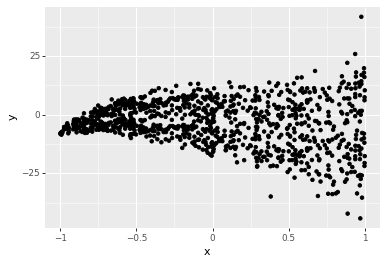

<ggplot: (166675208945)>

In [4]:
(
    pn.ggplot(df,
              pn.aes(x = 'x',
                     y = 'y'
                    )
             )
    + pn.geom_point()
)

# Question 2. Fit a simple line with `statsmodels`

In this question, you will fit a conditional expectation function, $E[Y_i | X_i=x]$, representing the expected outcome value, the average of $Y_i$, for observations in which the predictor, $X_i$, takes on the value of $x$. For the purposes of this question only, you will assume that the conditional expectation function follows the simple linear form $E[Y_i | X_i=x] = \alpha + \beta x_i$.

## 2.a Create design matrices

Using `patsy.dmatrices()`, create two `DataFrame` objects, `y` and `X`, that can later be used to fit the simple conditional expectation function described above.

In [5]:
y, X = patsy.dmatrices(
    'y ~ x + C(obstype)',
    data = df,
    return_type = 'dataframe'
)

Inspect `y` and `X` and describe their contents in 1–2 sentences.

YOUR DESCRIPTION HERE

## 2.b Define and estimate the model

Using `sm.OLS()`, define the model described above and store the result in an object called `lm_simple_model`. Then, use the `.fit()` method to fit the parameters of the assumed model. Store the fitted model in an object called `lm_simple_fitted`. In other words, obtain estimates of $\alpha$ and $\beta$. Closely examine the intermediate objects.

In [6]:

lm_simple_model = sm.OLS(y, X)

lm_simple_fitted = lm_simple_model.fit()


## 2.c Examine the results

After fitting the model, call `.summary()` on `lm_simple_fitted`. Carefully examine the output of the `.summary()` method and compare it to the output of `dir(lm_simple_fitted)`.
- Where does `.summary()` obtain the "coef" information? In other words, how can you access this directly from `lm_simple_fitted`? 
- Where does `.summary()` obtain the "std err" information?
- Where does `.summary()` obtain the "R-squared" information?

In [7]:
lm_simple_fitted.summary()

dir(lm_simple_fitted)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     634.4
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.85e-178
Time:                        22:24:23   Log-Likelihood:                -3286.2
No. Observations:                1000   AIC:                             6578.
Df Residuals:                     997   BIC:                             6593.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.4580      0.290     11.931      0.000       2.889       4.027
C(obstype)[T.b]   -14.1302      0.410    -34.476      0.000     -14.934     -13.326
x                  -3.2022      0.357     -8.960      0.000      -3.904      -2.501
==============================================================================
Omnibus:                       86.898   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              463.670
Skew:                          -0.149   Prob(JB):                    2.07e-101
Kurtosis:                       6.323   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_is_nested',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'info_c

- Where does `.summary()` obtain the "coef" information? In other words, how can you access this directly from `lm_simple_fitted`?
From the attribute "params" of lm_simple_fitted. By calling lm_simple_fitted.params. 
- Where does `.summary()` obtain the "std err" information?
From the attribute "bse" of lm_simple_fitted.
- Where does `.summary()` obtain the "R-squared" information?
From the attribute "rsquared" of lm_simple_fitted.

## 2.d Obtain predicted values

Get prediction results from the `lm_simple_fitted` model by calling the `.get_prediction()` method. Then, using the resulting object, get a `DataFrame` with one row per observation by calling the `.summary_frame()` method. Closely examine the intermediate objects.

Finally, using `pd.concat()`, combine the original `x`, `y`, and `obstype` with the model predictions. Store the result as `lm_simple_predictions_df`.

In your own words, briefly describe
- What `mean` represents
- What `mean_ci_lower` and `mean_ci_upper` represent
- What `obs_ci_lower` and `obs_ci_upper` represent

In [8]:
lm_simple_pred = lm_simple_fitted.get_prediction()

lm_simple_pred_df = lm_simple_pred.summary_frame()

lm_simple_predictions_df = pd.concat([df[['x', 'y', 'obstype']], lm_simple_pred_df], axis = 1)



## 2.e Compare model output with raw data

Using `plotnine`, make a bivariate scatterplot from `lm_simple_predictions_df` in which `x` is plotted on the horizontal axis and `y` is plotted on the vertical axis. Visualize your model output by adding the following elements:
- A translucent red ribbon representing `obs_ci_lower` and `obs_ci_upper`,
- A solid red ribbon representing `mean_ci_lower` and `mean_ci_upper`,
- A thin dashed blue line representing `mean`, and
- Facets representing observation types `a` and `b`.

Briefly describe your conclusions after examining the results. In particular:
- Does the assumption of homogeneity across observation types appear to be satisfied? Why?
- Does the assumption of linearity appear to be justified? Why?
- Does the assumption of homoskedasticity appear to be justified? Why?

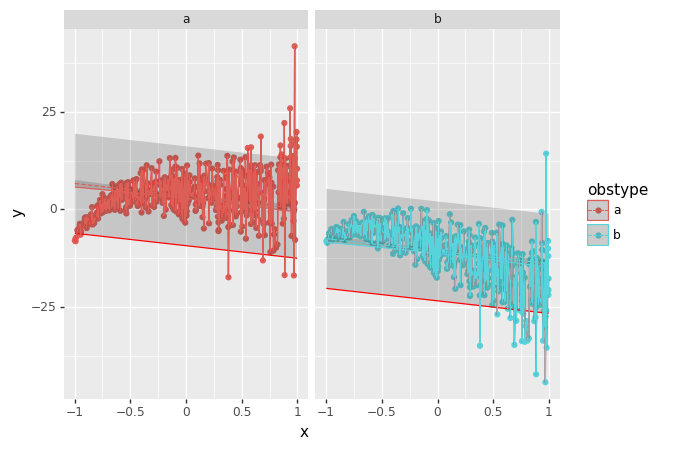

<ggplot: (166676098064)>

In [9]:
(
    pn.ggplot(lm_simple_predictions_df,
                pn.aes(x = 'x',
                          y = 'y',  
                            color = 'obstype'
                            )
                )
    + pn.geom_point()
    + pn.geom_ribbon(pn.aes(ymin = 'obs_ci_lower', ymax = 'obs_ci_upper'), alpha = 0.2, color = 'red')
    + pn.geom_ribbon(pn.aes(ymin = 'mean_ci_lower', ymax = 'mean_ci_upper'), alpha = 0.2)
    + pn.geom_line(pn.aes(y = 'mean'), linetype = 'dashed')
    + pn.facet_wrap('~ obstype')

)



- Does the assumption of homogeneity across observation types appear to be satisfied? Why?
Yes, because the confidence intervals for the two types of observations are very similar.
- Does the assumption of linearity appear to be justified? Why?
Yes, because the confidence intervals for the two types of observations are very similar.
- Does the assumption of homoskedasticity appear to be justified? Why?
Yes, because the confidence intervals for the two types of observations are very similar.

In [10]:
lm_simple_predictions = lm_simple_fitted.get_prediction()
lm_simple_predictions.summary_frame(alpha = .05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2.395064,0.314566,1.777776,3.012351,-10.336778,15.126905
1,-11.735107,0.314566,-12.352394,-11.117820,-24.466948,0.996734
2,5.193133,0.346529,4.513123,5.873144,-7.541903,17.928170
3,-8.937037,0.346529,-9.617048,-8.257027,-21.672074,3.797999
4,0.869122,0.411844,0.060942,1.677302,-11.873401,13.611645
...,...,...,...,...,...,...
995,-12.292792,0.343586,-12.967026,-11.618558,-25.027521,0.441937
996,2.080111,0.329827,1.432876,2.727345,-10.653217,14.813439
997,-12.050060,0.329827,-12.697294,-11.402825,-24.783388,0.683269
998,5.470161,0.364398,4.755086,6.185236,-7.266796,18.207118


## 2.f Estimate revised model allowing heterogeneity across observation types

Create new design matrices using the formula `y ~ obstype * x`. Carefully examine the output and describe what each column represents.

Then:
- Using `sm.OLS()`, define `lm_interact_model`,
- `.fit()` it and store the results as `lm_interact_fitted`, and
- Call `.summary()` on it

Finally, interpret the results. 
- What is the model estimate of $E[Y_i | X_i=0, \text{type}=\text{a}]$?
- What is the model estimate of $E[Y_i | X_i=0, \text{type}=\text{b}]$?
- Are the two conditional means significantly different? What is the $p$-value of the difference?
- What is the model estimate of the slope of $E[Y_i | X_i=x, \text{type}=\text{a}]$, or the amount that the expected value changes for each unit increase in $x$?
- What is the model estimate of the slope of $E[Y_i | X_i=x, \text{type}=\text{b}]$?
- Are the two slopes significantly different? What is the $p$-value of the difference?

In [11]:
y, X = patsy.dmatrices(
    'y ~ C(obstype) * x',
    data = df,
    return_type = 'dataframe'
)

lm_interact_model = sm.OLS(y, X)

lm_interact_fitted = lm_interact_model.fit()

lm_interact_fitted.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     692.1
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          4.95e-243
Time:                        22:24:24   Log-Likelihood:                -3133.5
No. Observations:                1000   AIC:                             6275.
Df Residuals:                     996   BIC:                             6295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.5175      0.249     14.131      0.000       3.029       4.006
C(obstype)[T.b]     -14.2492      0.352    -40.476      0.000     -14.940     -13.558
x                     2.5874      0.434      5.961      0.000       1.736       3.439
C(obstype)[T.b]:x   -11.5794      0.614    -18.864      0.000     -12.784     -10.375
==============================================================================
Omnibus:                      108.499   Durbin-Watson:                   0.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              848.089
Skew:                          -0.036   Prob(JB):                    6.91e-185
Kurtosis:                       7.511   Cond. No.                         4.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2.g Examine alternative model specifications

Create new design matrices using the following formulae. 
- `y ~ obstype + x`
- `y ~ 0 + obstype + x`
- `y ~ 0 + obstype + obstype : x`

For each one, examine the design matrices. Think about the parameter estimates that would be obtained by running `sm.OLS().fit()` on each one. (You do not need to actually estimate these models, but you are free to do so if it helps you answer this question). In comments, describe how you would interpret each parameter in terms of the following concepts:
- The model-estimated $E[Y_i | X_i=0, \text{type}=\text{a}]$
- The model-estimated $E[Y_i | X_i=0, \text{type}=\text{b}]$
- The model-estimated $E[Y_i | X_i=0, \text{type}=\text{b}] - E[Y_i | X_i=0, \text{type}=\text{a}]$
- The model-estimated slope of $E[Y_i | X_i=x, \text{type}=\text{a}]$
- The model-estimated slope of $E[Y_i | X_i=x, \text{type}=\text{b}]$
- The model-estimated difference in slopes, $E[Y_i | X_i=x, \text{type}=\text{b}] - E[Y_i | X_i=x, \text{type}=\text{a}]$

In [12]:
# complete the comments below in terms of
# E[Y|X=0, a]
# E[Y|X=0, b]
# slope of E[Y|X=x, a]
# slope of E[Y|X=x, b]


y, X = patsy.dmatrices(
    'y ~ obstype + x', 
    data = df,
    return_type = 'dataframe'
)
X.head()

# coef for intercept will be E[Y|X=0, a]
# coef for b will be E[Y|X=0, b]
# coef for x will be slope of E[Y|X=x, a]


,Intercept,obstype[T.b],x
0,1.0,0.0,0.331949
1,1.0,1.0,0.331949
2,1.0,0.0,-0.541837
3,1.0,1.0,-0.541837
4,1.0,0.0,0.808472


In [13]:
# complete the comments below in terms of
# E[Y|X=0, a]
# E[Y|X=0, b]
# slope of E[Y|X=x, a]
# slope of E[Y|X=x, b]

# coef for a will be E[Y|X=0, a]
# coef for b will be E[Y|X=0, b]
# coef for x will be slope of E[Y|X=x, a]
y, X = patsy.dmatrices(
    'y ~ 0 + obstype + x', 
    data = df,
    return_type = 'dataframe'
)
X.head()

,obstype[a],obstype[b],x
0,1.0,0.0,0.331949
1,0.0,1.0,0.331949
2,1.0,0.0,-0.541837
3,0.0,1.0,-0.541837
4,1.0,0.0,0.808472


In [14]:
# complete the comments below in terms of
# E[Y|X=0, a]
# E[Y|X=0, b]
# slope of E[Y|X=x, a]
# slope of E[Y|X=x, b]

# coef for a will be E[Y|X=0, a]
# coef for b will be E[Y|X=0, b]
# coef for a:x will be slope of E[Y|X=x, a]
# coef for b:x will be slope of E[Y|X=x, b]

y, X = patsy.dmatrices(
    'y ~ 0 + obstype + obstype:x', 
    data = df,
    return_type = 'dataframe'
)
X.head()

,obstype[a],obstype[b],obstype[a]:x,obstype[b]:x
0,1.0,0.0,0.331949,0.000000
1,0.0,1.0,0.000000,0.331949
2,1.0,0.0,-0.541837,-0.000000
3,0.0,1.0,-0.000000,-0.541837
4,1.0,0.0,0.808472,0.000000


# Question 3. Obtain standard errors that reflect heteroskedasticity and clustering

In the previous question, the `.summary()` output notes that "Standard Errors assume that the covariance matrix of the errors is correctly specified." In particular, previous results assumed that
- Each unit was independent and identically distributed, and
- The conditional variance of the outcome, $\text{Var}(Y_i | X_i=x)$, was identical for all values of $x$.

In fact, neither of these assumptions is true. In this question, you will obtain results that are robust to these concerns.

## 3.a Heteroskedasticity

First, the data is heteroskedastic: observations with larger values of $X_i$ have greater variance in $Y_i$. Call `.fit()` again and provide the argument `cov_type = 'HC3'` to obtain heteroskedasticity-consistent standard errors. Store the result as `lm_simple_fitted_robust`. Use `.summary()` to summarize the model results.

In [15]:
# use a different method for computing standard errors by specifying cov_type
lm_simple_fitted_robust = lm_simple_model.fit(cov_type = 'HC3')
lm_simple_fitted_robust.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     595.9
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          5.82e-171
Time:                        22:24:24   Log-Likelihood:                -3286.2
No. Observations:                1000   AIC:                             6578.
Df Residuals:                     997   BIC:                             6593.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.4580      0.296     11.676      0.000       2.878       4.039
C(obstype)[T.b]   -14.1302      0.411    -34.400      0.000     -14.935     -13.325
x                  -3.2022      0.467     -6.852      0.000      -4.118      -2.286
==============================================================================
Omnibus:                       86.898   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              463.670
Skew:                          -0.149   Prob(JB):                    2.07e-101
Kurtosis:                       6.323   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

## 3.b Clustering

Second, the data is clustered: `x` values are identical for observations within a cluster, and `y` values are highly correlated.

### 3.b.i Examine clustering

Pivot the data so that
- Each row represents a cluster, and
- There are two columns, respectively containing the `y` values for observation types `a` and `b`.

Then, use the `.corr()` method to examine the correlation. Briefly summarize the results in your own words.

In [16]:
df_pivot = df.pivot(index = 'cluster', columns = 'obstype', values = 'y')
df_pivot.head()

df_pivot.corr()



obstype,a,b
cluster,,
0,-0.990330,-18.013248
1,5.384872,-3.473841
2,-9.807677,-33.593956
3,6.598524,-5.436500
4,5.675148,-7.709509


obstype,a,b
obstype,,
a,1.000000,0.518821
b,0.518821,1.000000


The correlation between the two types of observations is high.


### 3.b.iii Obtain cluster-robust standard errors

Call `.fit()` again and provide the argument `cov_type = 'cluster'` to obtain cluster-robust standard errors (note that these also account for heteroskedasticity). You will also need to provide the `cov_kwds` argument, which takes a dictionary as input. In the context of clustered standard errors, this dictionary should have a 'groups' key. The corresponding value in this dictionary should be a `Series` in which each unique value represents a cluster or group name/number. Note that this `Series` must have the same number of rows as the input to `sm.OLS()`, which can be fewer than the original data if some observations are dropped due to missingness.

Store the result as `lm_simple_fitted_cluster`. Use `.summary()` to summarize the model results.

In [17]:
lm_simple_fitted_cluster = lm_simple_model.fit(cov_type = 'cluster', cov_kwds = {'groups': df.cluster})
lm_simple_fitted_cluster.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     1107.
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          3.60e-184
Time:                        22:24:25   Log-Likelihood:                -3286.2
No. Observations:                1000   AIC:                             6578.
Df Residuals:                     997   BIC:                             6593.
Df Model:                           2                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.4580      0.297     11.641      0.000       2.876       4.040
C(obstype)[T.b]   -14.1302      0.300    -47.044      0.000     -14.719     -13.541
x                  -3.2022      0.543     -5.895      0.000      -4.267      -2.138
==============================================================================
Omnibus:                       86.898   Durbin-Watson:                   1.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              463.670
Skew:                          -0.149   Prob(JB):                    2.07e-101
Kurtosis:                       6.323   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

## 3.c Comparison of results

Using your answer to 2.c, extract the estimated parameters and standard errors for `lm_simple_fitted`, `lm_simple_fitted_robust`, and `lm_simple_fitted_cluster`. How do they differ?

In [18]:
lm_simple_fitted.params
lm_simple_fitted.bse
lm_simple_fitted.rsquared

lm_simple_fitted_robust.params
lm_simple_fitted_robust.bse
lm_simple_fitted_robust.rsquared

lm_simple_fitted_cluster.params
lm_simple_fitted_cluster.bse
lm_simple_fitted_cluster.rsquared


Intercept           3.458043
C(obstype)[T.b]   -14.130171
x                  -3.202239
dtype: float64

Intercept          0.289837
C(obstype)[T.b]    0.409859
x                  0.357392
dtype: float64

0.5599894539397956

Intercept           3.458043
C(obstype)[T.b]   -14.130171
x                  -3.202239
dtype: float64

Intercept          0.296161
C(obstype)[T.b]    0.410764
x                  0.467365
dtype: float64

0.5599894539397956

Intercept           3.458043
C(obstype)[T.b]   -14.130171
x                  -3.202239
dtype: float64

Intercept          0.297064
C(obstype)[T.b]    0.300361
x                  0.543211
dtype: float64

0.5599894539397956

They are very similar

# Question 4. Explore model specifications with `plotnine`

As Question 1 demonstrates, the simple linear model is a poor fit to this data. In other words, the rigid parametric assumptions about the linear functional form of the conditional expectation appear to be violated.

In this question, we will explore the data nonparametrically by binning observations and visualizing the mean values within each bin. We will attempt to visually identify a more reasonable model specification.

## 4.a Visualize linear model

Make a scatterplot with `x` and `y`, faceted by observation type. Using `stat_smooth()` with `method = 'lm'`, add a line to each panel.

Fine-tune the results of `stat_smooth()` to display the confidence intervals with a translucent blue ribbon and the fitted line with a dotted blue line.

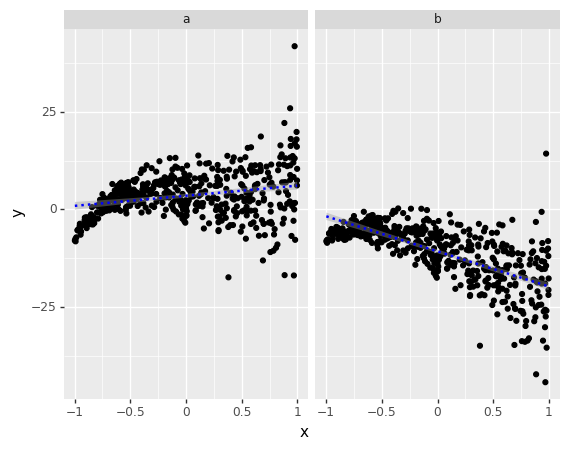

<ggplot: (166676218733)>

In [19]:
(
    pn.ggplot(df,
                pn.aes(x = 'x',
                            y = 'y'
                            )
                )
    + pn.geom_point()
    + pn.stat_smooth(method = 'lm', se = True, color = 'blue', linetype = 'dotted')
    + pn.facet_wrap('~ obstype')
)


## 4.b Compare linear model to binned means

Create a new plot. Using `stat_summary_bin()`, make 10 red errorbars per panel, representing the means within 10 bins of `x`.

Overlay the linear model from `stat_smooth()`. For this and all subsequent plots, you may omit the raw data points.

Compare the results. Is a linear model a good fit to the data?

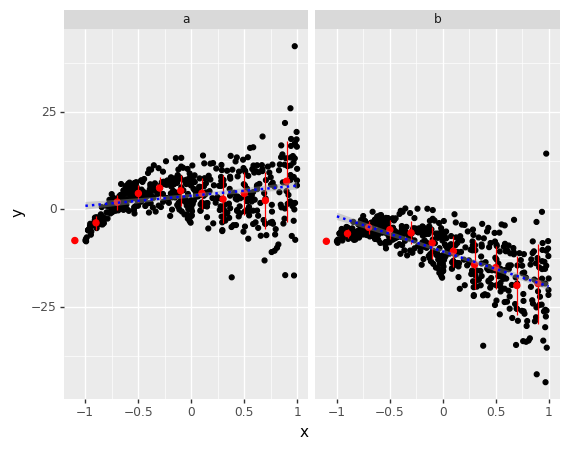

<ggplot: (166676750330)>

In [20]:
# Create a new plot. Using `stat_summary_bin()`, make 10 red errorbars per panel, representing the means within 10 bins of `x`

(
    pn.ggplot(df,
                pn.aes(x = 'x',
                            y = 'y'
                            )
    )
    + pn.geom_point()
    + pn.stat_summary_bin(fun_y = np.mean, fun_ymin = lambda x: np.mean(x) - np.std(x), fun_ymax = lambda x: np.mean(x) + np.std(x), color = 'red', bins = 10)
    + pn.stat_smooth(method = 'lm', se = True, color = 'blue', linetype = 'dotted')
    + pn.facet_wrap('~ obstype')
)

#A linear model is not a good fit.

## 4.c Identify a reasonable model specification

Try providing different `formula` arguments to `stat_smooth()` to identify a reasonable model specification.

Note that `stat_smooth()` will only accept formulas with the terms `x` and `y`. The same formula will automatically be used within groups defined by color, facet, etc. (These refer to the `x` and `y` aesthetic, not the column names in your data; for example, if you previously defined `pn.aes(x = 'predictor', y = 'outcome')`, then you would still use `formula = 'y ~ x'` to obtain a linear regression.)

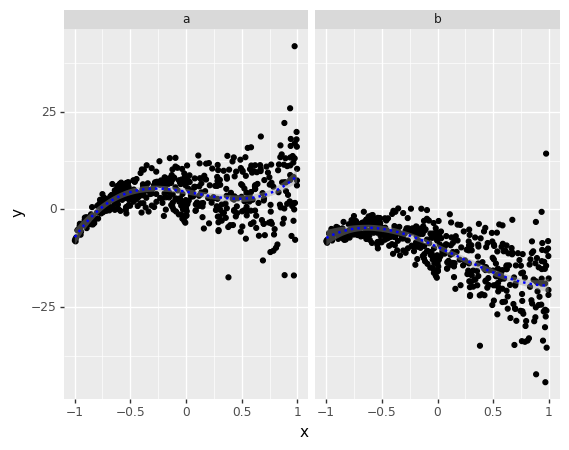

<ggplot: (166676735395)>

In [21]:
# using locally weighted regression for `formula` argument
(
    pn.ggplot(df,
                pn.aes(x = 'x',
                            y = 'y'
                            )
    )
    + pn.geom_point()
    + pn.stat_smooth(method = 'lm', formula = 'y ~ x + I(x**2) + I(x**3)', se = True, color = 'blue', linetype = 'dotted')
    + pn.facet_wrap('~ obstype')
)

# Question 5. Estimate a better fitting model

In this question, you will go back and estimate a better fitting `OLS()` model.

## 5.a Create design matrices, estimate models

Using `patsy.dmatrices()`, create design matrices `y` and `X` that can be used to fit the most reasonable model plotted in Question 4. Examine the head of `X` and briefly describe what each column represents.

Fit the model using clustered standard errors. Store the result as `lm_best_fitted`.

**Hint:** `plotnine` automatically estimates separate regressions with the specified form (e.g. `formula = 'y ~ 1 + x'`) within each group defined by color aesthetics, faceted panels, etc. To obtain the same results from `patsy.dmatrices()` and `sm.OLS()`, you will need to add interaction terms to each term in your formula from 4.c, allowing that parameter to vary across groups. For example, if you group by `obstype` in `plotnine`, you will by default obtain intercepts and slopes that vary across groups 'a' and 'b'. To obtain the same result here, you will need to use `formula = 'y ~ obstype + obstype : x'` (or an equivalent specification such as `y ~ obstype * x`).

In [22]:
y, X = patsy.dmatrices(
    'y ~ 0 + obstype + obstype:x + x + I(x**2) + I(x**3)',
    data = df,
    return_type = 'dataframe'
)

X.head()

lm_best_model = sm.OLS(y, X)

lm_best_fitted = lm_best_model.fit()


,obstype[a],obstype[b],x,obstype[T.b]:x,I(x ** 2),I(x ** 3)
0,1.0,0.0,0.331949,0.000000,0.110190,0.036577
1,0.0,1.0,0.331949,0.331949,0.110190,0.036577
2,1.0,0.0,-0.541837,-0.000000,0.293587,-0.159076
3,0.0,1.0,-0.541837,-0.541837,0.293587,-0.159076
4,1.0,0.0,0.808472,0.000000,0.653627,0.528440


## 5.b Visualize results

Using the fitted model from 5.a, obtain predicted means with 95% confidence intervals. Concatenate the results with `df.loc[:, ['obstype', 'x']]`.

As in question 2.e, make a plot based on `lm_best_predictions_df` in which `x` is plotted on the horizontal axis and `y` is plotted on the vertical axis. Visualize your model output by adding the following elements:
- A translucent red ribbon representing `mean_ci_lower` and `mean_ci_upper`,
- A thin dashed blue line representing `mean`, and
- Facets representing observation types `a` and `b`.

,obstype,x,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,a,0.331949,3.519707,0.354795,2.823474,4.215940,-6.861771,13.901185
1,b,0.331949,-14.573228,0.354795,-15.269461,-13.876995,-24.954706,-4.191749
2,a,-0.541837,3.605666,0.360559,2.898121,4.313211,-6.776577,13.987909
3,b,-0.541837,-4.369395,0.360559,-5.076940,-3.661850,-14.751638,6.012848
4,a,0.808472,4.791890,0.443070,3.922430,5.661350,-5.602643,15.186422
...,...,...,...,...,...,...,...,...
995,b,0.506104,-16.773362,0.380114,-17.519281,-16.027444,-27.158291,-6.388434
996,a,0.430303,3.351862,0.371752,2.622353,4.081371,-7.031901,13.735625
997,b,0.430303,-15.879948,0.371752,-16.609457,-15.150440,-26.263711,-5.496185
998,a,-0.628347,2.615282,0.369321,1.890543,3.340021,-7.768147,12.998711


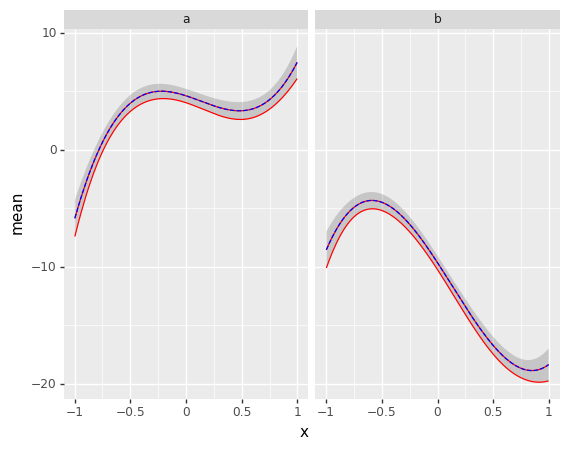

<ggplot: (166676913963)>

In [23]:
lm_best_predictions = lm_best_fitted.get_prediction()
lm_best_predictions_df = pd.concat(
    [
        df.loc[:, ['obstype', 'x']],
        lm_best_predictions.summary_frame(alpha = .05)
    ],
    axis = 1
)
lm_best_predictions_df

(
    pn.ggplot(lm_best_predictions_df,
                pn.aes(x = 'x',
                            y = 'mean',
                            ymin = 'mean_ci_lower', 
                            ymax = 'mean_ci_upper'
                            )
    )
    + pn.geom_ribbon(alpha = .2, color = 'red')
    + pn.geom_line(color = 'blue', linetype = 'dashed')
    + pn.facet_wrap('~ obstype')
)



## 5.c Interpret results

You are asked to design a policy based on your model. The policy involves a targeted intervention that will increase `x` by 0.01 for each unit receiving the intervention. The goal is to allocate this intervention in a way that will maximize `y`.

First, examine the following code carefully and add comments explaining what each step does.

Then, answer the following questions:
- If you were able to target 50 units for this intervention, which 50 units would you select? Why?
- What are the characteristics of units that will benefit from the intervention? Why?

In [24]:

y, X_perturbed = patsy.dmatrices(
    'y ~ obstype * x + obstype * I(x ** 2) + obstype * I(x ** 3)',  # this is the formula
    data = df.assign(x = df.x + .01), # this perturbs the x values
    return_type = 'dataframe'
)

In [25]:
# create a new dataframe with the perturbed x values
lm_best_predictions_df = lm_best_predictions_df.rename(columns = {'mean' : 'y_pred'})

In [26]:
# add a new column with the perturbed predictions
lm_best_predictions_df = lm_best_predictions_df.assign(
    y_pred_perturbed = (
        lm_best_fitted
        .get_prediction(X_perturbed)  # this is the perturbed data
        .predicted_mean               # this is the predicted mean
    )
)

ValueError: shapes (1000,8) and (6,) not aligned: 8 (dim 1) != 6 (dim 0)

In [27]:
# add a new column with the slope
lm_best_predictions_df = lm_best_predictions_df.assign(
    y_slope = (
        lm_best_predictions_df.y_pred_perturbed  # this is the perturbed prediction
        - lm_best_predictions_df.y_pred          # this is the original prediction
    ) / .01                                      # this is the perturbation
)

AttributeError: 'DataFrame' object has no attribute 'y_pred_perturbed'

# Question 6. Fitting decision trees

In this question, you will fit a conditional expectation function, $E[Y_i | \text{type}, X_i=x]$, representing the expected outcome value, the average of $Y_i$, for observations of the specified type in which the predictor, $X_i$, takes on the value of $x$. For the purposes of this question only, you will assume that the conditional expectation function follows a piecewise constant form. You will use the design matrices defined below.

In [28]:
y, X = patsy.dmatrices(
    'y ~ 0 + x + obstype', 
    data = df,
    return_type = 'dataframe'
)
pd.concat([y, X], axis = 1).head()

,y,obstype[a],obstype[b],x
0,-0.990330,1.0,0.0,0.331949
1,-18.013248,0.0,1.0,0.331949
2,5.384872,1.0,0.0,-0.541837
3,-3.473841,0.0,1.0,-0.541837
4,-9.807677,1.0,0.0,0.808472


## 6.a Define and estimate a simple decision tree

Using `sklearn.tree.DecisionTreeRegressor()`, define a decision tree model in which you allow a maximum of two leaf nodes (i.e., two pieces in the piecewise constant conditional expectation function). Store the stated model as `tree2_model`.

Then, call `.fit()` on it and store the estimated model as `tree2_fitted`.

In [29]:
import sklearn.tree


tree2_model = sklearn.tree.DecisionTreeRegressor(max_leaf_nodes = 2)
tree2_fitted = tree2_model.fit(X, y)



## 6.b Visualize a simple decision tree

Provide your `tree2_fitted` object to the `sklearn.tree.plot_tree()` function. This function will produce a visual representation of the estimated model, showing the decision rules used to split the data and generate predictions. The results will be reported in terms of column indices in your `X` design matrix (e.g., split on whether `X[1] <= 0.5`) unless you supply `feature_names`, in which case the plot will look up the name of each column in `X` in that list. Carefully inspect the resulting plot.

Next, use the `.predict()` method of your estimated decision tree to obtain predictions for each observation in `X`. Append the results to your original `df` as a new column named `tree2_prediction`. Create a plot of the raw data points in black, faceted by `obstype`, then overlay `tree2_prediction` in red. 

Finally, in the title of your plot, describe the behavior of `tree2_fitted` in your own words. You are free to use mathematical notation or plain English, as long as your explanation is clear and correct.

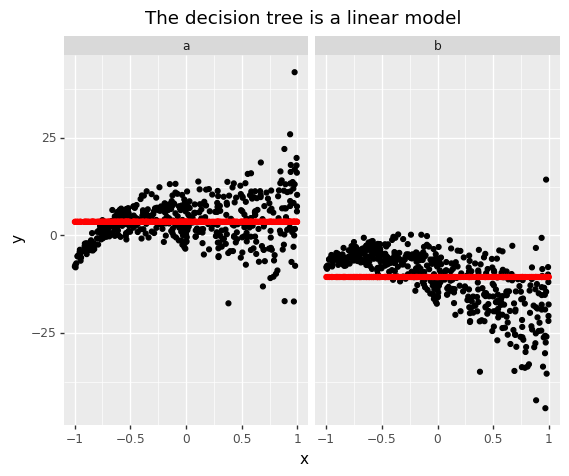

<ggplot: (166676736567)>

In [30]:
tree2_predictions = tree2_fitted.predict(X)
df = df.assign(tree2_prediction = tree2_predictions)

(
    pn.ggplot(df,
                pn.aes(x = 'x',
                            y = 'y'
                            )
    )
    + pn.geom_point(color = 'black')
    + pn.geom_point(pn.aes(y = 'tree2_prediction'), color = 'red')
    + pn.facet_wrap('~ obstype')
    + pn.labs(title = 'The decision tree is a linear model')
)



## 6.c Estimate and visualize more complex decision trees

In this question, you will repeat 2.a–b using tree models with 4, 16, and 100 leaf nodes. Store the fitted models as `tree4_fitted`, `tree16_fitted`, and `tree100_fitted`, and concatenate the predictions as new columns in `df` named `tree4_prediction`, `tree16_prediction`, and `tree100_prediction`. For each model, visualize the decision tree using `sklearn.tree.plot_tree()` and the estimated conditional expectation function with `plotnine`.

After completing these tasks, return to the following Markdown cell and write down your assessment of how decision tree model performance varies with `max_leaf_nodes`. What are the advantages and disadvantages of smaller/larger values?

Too many leaf nodes can lead to overfitting, which can lead to poor performance on new data. Too few leaf nodes can lead to underfitting, which can lead to poor performance on new data.

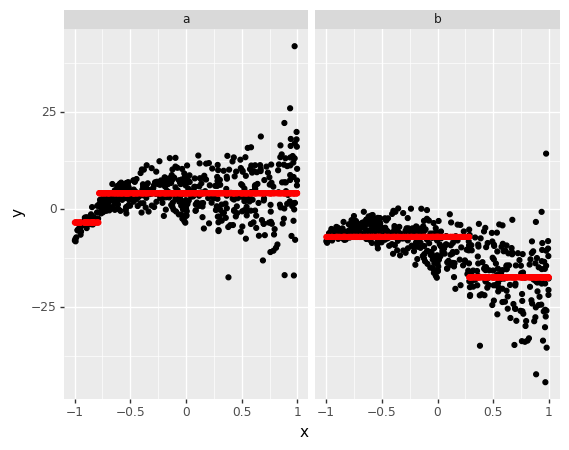

<ggplot: (166675775552)>

In [31]:
tree4_model = sklearn.tree.DecisionTreeRegressor(max_leaf_nodes = 4)
tree4_fitted = tree4_model.fit(X, y)
tree4_predictions = tree4_fitted.predict(X)
df = df.assign(tree4_prediction = tree4_predictions)

(
    pn.ggplot(df,
                pn.aes(x = 'x',
                            y = 'y'
                            )
    )
    + pn.geom_point(color = 'black')
    + pn.geom_point(pn.aes(y = 'tree4_prediction'), color = 'red')
    + pn.facet_wrap('~ obstype')
)  

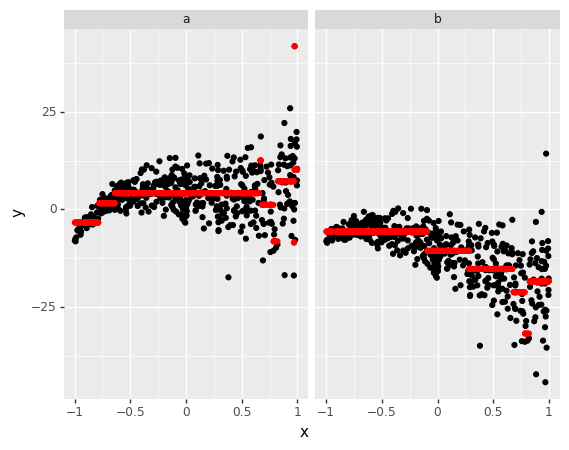

<ggplot: (166678873348)>

In [32]:
tree16_model = sklearn.tree.DecisionTreeRegressor(max_leaf_nodes = 16)
tree16_fitted = tree16_model.fit(X, y)
tree16_predictions = tree16_fitted.predict(X)
df = df.assign(tree16_prediction = tree16_predictions)

(
    pn.ggplot(df,
                pn.aes(x = 'x',
                            y = 'y'
                            )
    )
    + pn.geom_point(color = 'black')
    + pn.geom_point(pn.aes(y = 'tree16_prediction'), color = 'red')
    + pn.facet_wrap('~ obstype')
)

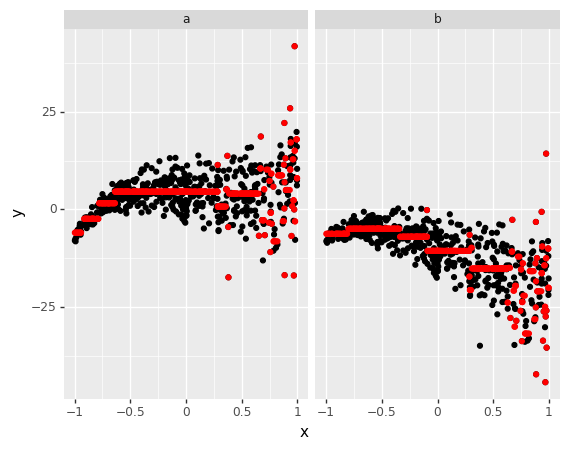

<ggplot: (166679126962)>

In [33]:
tree100_model = sklearn.tree.DecisionTreeRegressor(max_leaf_nodes = 100)
tree100_fitted = tree100_model.fit(X, y)
tree100_predictions = tree100_fitted.predict(X)
df = df.assign(tree100_prediction = tree100_predictions)

(
    pn.ggplot(df,
                pn.aes(x = 'x',
                            y = 'y'
                            )
    )
    + pn.geom_point(color = 'black')
    + pn.geom_point(pn.aes(y = 'tree100_prediction'), color = 'red')
    + pn.facet_wrap('~ obstype')
)

## 6.d Alternative regularization parameter

In the preceding question, you examined one of several regularization parameters that control the complexity of the fitted conditional expectation function. In this question, you will return to the 100-leaf decision tree and explore an alternative approach for regularization. Refit this model with `min_samples_leaf = 25` and store the result as `tree100_min25_model`. Visualize the decision tree and conditional expectation function as above. 

Then, return to the following Markdown cell and describe how the estimation of a decision tree varies with `min_samples_leaf`. What are the advantages and disadvantages of smaller/larger values?

Finally, describe how you expect the best-performing values of `max_leaf_nodes` and `min_samples_leaf` to change for hypothetical samples of N=100, 1,000, and 10,000 observations from the data-generating process outlined in part 1.

The estimation of a decision tree varies with `min_samples_leaf` in that it will not split a node if the number of samples in the node is less than `min_samples_leaf`. This can lead to underfitting, which can lead to poor performance on new data. The best-performing values of `max_leaf_nodes` and `min_samples_leaf` will likely increase as the sample size increases.

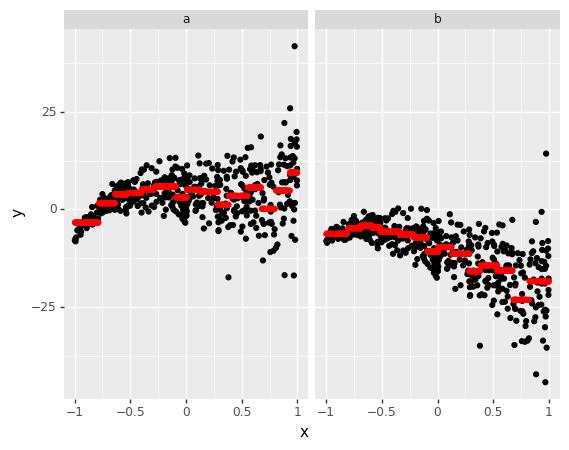

<ggplot: (166679112045)>

In [34]:
tree100_min25_model = sklearn.tree.DecisionTreeRegressor(max_leaf_nodes = 100, min_samples_leaf = 25)
tree100_min25_fitted = tree100_min25_model.fit(X, y)
tree100_min25_predictions = tree100_min25_fitted.predict(X)
df = df.assign(tree100_min25_prediction = tree100_min25_predictions)

(
    pn.ggplot(df,
                pn.aes(x = 'x',
                            y = 'y'
                            )
    )
    + pn.geom_point(color = 'black')
    + pn.geom_point(pn.aes(y = 'tree100_min25_prediction'), color = 'red')
    + pn.facet_wrap('~ obstype')
)


# Question 7. Cross-validation

A common approach for model selection is "K-fold cross validation," a variation of the train-test splitting paradigm in which a trained model is tested using data that it has not previously seen (and hence cannot simply memorize). In K-fold cross validation:
1. The data is divided into K roughly balanced "folds" (typically, K=5 or K=10), ensuring that all potentially dependent observations (i.e. those within a cluster) are all assigned to the same fold to prevent information from bleeding across folds.
2. A candidate model is trained on data from folds 2 to K, holding out the first fold during the training process. The model is then tested on the K-th fold using a metric like (i) the proportion of variance in the unseen outcomes that is explained by the model or (ii) the overall model-predicted likelihood of the unseen outcomes.
3. Step 2 is repeated while holding out folds 2–K as separate test sets.
4. The model that exhibits the best overall performance, aggregating over the K training/testing rounds, is selected.

When implemented correctly, this approach has what is known as the "oracle" property. Roughly speaking, this means that as the number of observations grows large, K-fold cross validation is guaranteed to eventually select the same model (among the candidate models examined) as an oracle that simply picks the one closest to the true data-generating process.

## 7.a Familiarize with data splitting

Before proceeding to model selection, you will first familiarize with the basic mechanics of sample splitting. The code below will generate an object that repeatedly splits your data. Call the `next()` function on `groupkfold_split_generator` and carefully examine the output. Then, call `next()` repeatedly until you obtain an error.

Write code that appends a new column to `df`, where each entry represents the fold to which the unit is assigned. Examine the fold assignments for the first 20 units.

After completing this exploration, write comments that describe the behavior of the code below.

In [35]:
# this defines the k-fold splitter which splits the data into 5 folds
splitter = sklearn.model_selection.GroupKFold(n_splits = 5)

# this calls the splitter to split the data
groupkfold_split_generator = splitter.split(X, y, df.cluster)

In [36]:
next(groupkfold_split_generator)
next(groupkfold_split_generator)
next(groupkfold_split_generator)

(array([  0,   1,   4,   5,   6,   7,   8,   9,  10,  11,  14,  15,  16,
         17,  18,  19,  20,  21,  24,  25,  26,  27,  28,  29,  30,  31,
         34,  35,  36,  37,  38,  39,  40,  41,  44,  45,  46,  47,  48,
         49,  50,  51,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  70,  71,  72,  73,  74,  75,  76,  77,  80,
         81,  82,  83,  84,  85,  86,  87,  90,  91,  92,  93,  94,  95,
         96,  97, 100, 101, 102, 103, 104, 105, 106, 107, 110, 111, 112,
        113, 114, 115, 116, 117, 120, 121, 122, 123, 124, 125, 128, 129,
        130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143, 146,
        147, 148, 149, 150, 151, 152, 153, 156, 157, 158, 159, 160, 161,
        162, 163, 166, 167, 168, 169, 170, 171, 172, 173, 176, 177, 178,
        179, 180, 181, 182, 183, 184, 185, 188, 189, 190, 191, 192, 193,
        194, 195, 196, 197, 200, 201, 202, 203, 204, 205, 206, 207, 210,
        211, 212, 213, 214, 215, 216, 217, 220, 221

(array([  0,   1,   2,   3,   6,   7,   8,   9,  10,  11,  12,  13,  16,
         17,  18,  19,  20,  21,  22,  23,  26,  27,  28,  29,  30,  31,
         32,  33,  36,  37,  38,  39,  40,  41,  42,  43,  46,  47,  48,
         49,  50,  51,  52,  53,  56,  57,  58,  59,  60,  61,  64,  65,
         66,  67,  68,  69,  72,  73,  74,  75,  76,  77,  78,  79,  82,
         83,  84,  85,  86,  87,  88,  89,  90,  91,  94,  95,  96,  97,
         98,  99, 102, 103, 104, 105, 106, 107, 108, 109, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 138, 139, 140, 141, 142,
        143, 144, 145, 148, 149, 150, 151, 152, 153, 154, 155, 158, 159,
        160, 161, 162, 163, 164, 165, 168, 169, 170, 171, 172, 173, 174,
        175, 178, 179, 180, 181, 184, 185, 186, 187, 188, 189, 192, 193,
        194, 195, 196, 197, 198, 199, 202, 203, 204, 205, 206, 207, 208,
        209, 212, 213, 214, 215, 216, 217, 218, 219

(array([  0,   1,   2,   3,   4,   5,   8,   9,  10,  11,  12,  13,  14,
         15,  18,  19,  20,  21,  22,  23,  24,  25,  28,  29,  30,  31,
         32,  33,  34,  35,  38,  39,  40,  41,  42,  43,  44,  45,  48,
         49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  74,  75,  76,  77,  78,
         79,  80,  81,  84,  85,  86,  87,  88,  89,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 104, 105, 106, 107, 108, 109, 110,
        111, 114, 115, 116, 117, 118, 119, 122, 123, 124, 125, 126, 127,
        130, 131, 132, 133, 134, 135, 136, 137, 140, 141, 142, 143, 144,
        145, 146, 147, 150, 151, 152, 153, 154, 155, 156, 157, 160, 161,
        162, 163, 164, 165, 166, 167, 170, 171, 172, 173, 174, 175, 176,
        177, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
        194, 195, 196, 197, 198, 199, 200, 201, 204, 205, 206, 207, 208,
        209, 210, 211, 214, 215, 216, 217, 218, 219

In [37]:
# Write code that appends a new column to `df`, where each entry represents the fold to which the unit is assigned.
df = df.assign(fold = 0)
for fold, (train_index, test_index) in enumerate(splitter.split(X, y, df.cluster)):
    df.loc[test_index, 'fold'] = fold

    

## 7.b Use K-fold cross validation for model selection

Carefully review the code below, which searches over a grid of possible decision-tree regularization/tuning parameter combinations to identify the one that performs best (defined here in terms of $R^2$, or the proportion of variance explained, for out-of-sample test observations).

Create a plot that investigates how performance varies with (i) maximum number of leaf nodes in the decision tree and (ii) the minimum number of training samples used in each leaf. Then, return to the Markdown cell below and answer the following four questions.

How does out-of-sample performance change as the maximum number of leaf nodes in the decision tree grows larger...
- When the minimum number of training samples in each leaf is small?
- When the minimum number of training samples in each leaf is moderate?
- When the minimum number of training samples in each leaf is large?

Why? What is the principle that underlies these findings?

1. Out-of-sample performance increases... when... small.
2. Out-of-sample performance increases... when... moderate. 
3. Out-of-sample performance decreases... when... large. 
Because the model is more flexible and can better fit the data.

In [38]:
# define a grid of parameter settings to evaluate
param_grid = {
    'max_leaf_nodes' : [5, 10, 15, 20, 25, 30, 35, 40],
    'min_samples_leaf' : [1, 4, 9, 16, 25, 36, 49]
}

# define a generic model that will accept those parameters as inputs
tree_model = sklearn.tree.DecisionTreeRegressor()

In [39]:
# define the grid search task:
# - run the tree model
# - with every combination of parameters supplied
# - trained on every combination of K-1 training folds
#   and evaluated on every held-out test fold
# - in search of the parameter combination with the 
#   best overall performance on held-out data
tree_gridsearch = sklearn.model_selection.GridSearchCV(
    tree_model,
    param_grid = param_grid,
    cv = splitter.split(X, y, df.cluster)
)

# run grid search
tree_gridsearch.fit(X, y)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000026CEDA72580>,
             estimator=DecisionTreeRegressor(),
             param_grid={'max_leaf_nodes': [5, 10, 15, 20, 25, 30, 35, 40],
                         'min_samples_leaf': [1, 4, 9, 16, 25, 36, 49]})

In [40]:
# collect results in param_max_leaf_nodes.astype("float")
tree_cv_perf_df = pd.DataFrame(tree_gridsearch.cv_results_)
tree_cv_perf_df.param_max_leaf_nodes = tree_cv_perf_df.param_max_leaf_nodes.astype('int')

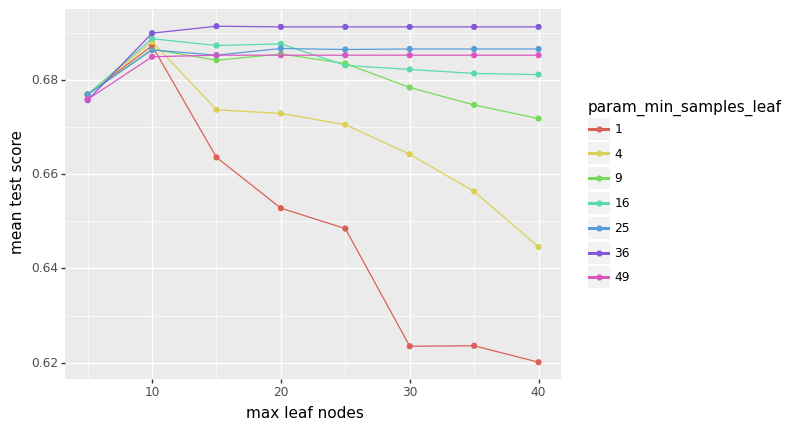

<ggplot: (166679227284)>

In [41]:
# plot results
(
    pn.ggplot(tree_cv_perf_df,
                pn.aes(x = 'param_max_leaf_nodes',
                            y = 'mean_test_score',
                            color = 'param_min_samples_leaf'
                            )
    )
    + pn.geom_point()
    + pn.geom_line()
    + pn.labs(x = 'max leaf nodes', y = 'mean test score')
)




## 7.c Investigate the best-performing decision tree identified by K-fold cross validation

The best-performing decision tree can be extracted with `tree_best = tree_gridsearch.best_estimator_`. Obtain its predictions with `.predict(X)` and store them as a new column in `df` named `tree_best_predictions`.

Visualize this decision tree and its predictions, as in question 2.b, and assess whether the parameters selected by K-fold cross validation appear to produce sensible predictions.

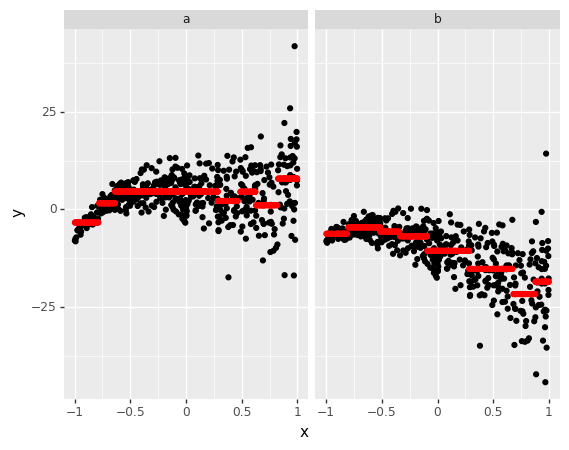

<ggplot: (166679277794)>

In [42]:
tree_best = tree_gridsearch.best_estimator_
tree_best_predictions = tree_best.predict(X)
df = df.assign(tree_best_predictions = tree_best_predictions)

(
    pn.ggplot(df,
                pn.aes(x = 'x',
                            y = 'y'
                            )
    )
    + pn.geom_point(color = 'black')
    + pn.geom_point(pn.aes(y = 'tree_best_predictions'), color = 'red')
    + pn.facet_wrap('~ obstype')
)

# It appears to product sensible results.

# Question 8. Fitting ensembles of trees with XGBoost

In this question, you will estimate the conditional expectation function using an alternative method, extreme gradient boosting, as implemented in the `xgboost` module. The basic approach of boosting algorithms is
1. Fit a relatively weak learner, such as a decision tree, on a training set
2. Identify the training observations that are poorly explained by the current model
3. Upweight those training observations and fit another weak learner to correct for previous errors
4. Aggregate the new learner by weighted combination with the previous model
5. Iterate steps 2–4
This produces an ensemble of weak learners that generally outperforms any individual component of the ensemble, often by a substantial margin.

In this question, you will first estimate a basic `xgboost` model and examine the results. Then, you will use cross validation to identify better-performing regularization parameters. Finally, you will compare predictions from the best-performing `xgboost` model to those obtained from other approaches.

## 8.a Fit default `xgboost` model

First, use `pip` to install `xgboost` and `import xgboost as xgb`. Using the code provided below, estimate the conditional expectation function using default `xgboost` parameter settings.

Then, use `xgb.plot_tree()` to visualize the structure of several decision trees in the ensemble. The i-th tree can be plotted by supplying `num_trees = i`. You do not need to read or interpret the tree; the goal here is simply to get a sense of its complexity.

Finally, plot the model predictions against the raw data, as in question 2.b. In the title of your plot, draw a conclusion about how well the model fits the data.

In [43]:
!pip install xgboost
import xgboost as xgb


In [44]:
# avoids error: "feature_names must be string, and may not contain [, ] or <"
X_renamed = X.rename(
    columns = {
        'obstype[a]' : 'obstype_a',
        'obstype[b]' : 'obstype_b'
    }
)

In [45]:
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror',
                             random_state = 19104
                            )

xgb_fitted = xgb_model.fit(X_renamed, y)

In [46]:
#!pip install graphviz

In [47]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

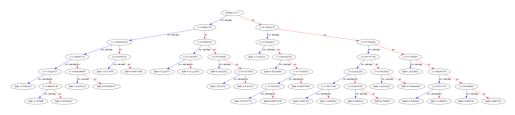

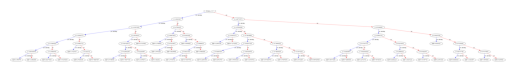

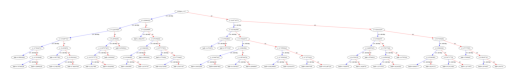

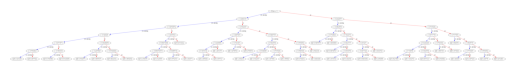

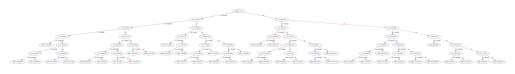

In [52]:
xgb.plot_tree(xgb_fitted, num_trees = 0)
xgb.plot_tree(xgb_fitted, num_trees = 1)
xgb.plot_tree(xgb_fitted, num_trees = 2)
xgb.plot_tree(xgb_fitted, num_trees = 3)
xgb.plot_tree(xgb_fitted, num_trees = 4)


## 8.b Use K-fold cross validation for model selection¶

Using the following parameter grid, use K-fold cross validation to conduct a grid search for the optimal parameters of the `xgb.XGBRegressor()` model.

Create a `DataFrame` of results and store it in `xgb_cv_perf_df`. Create a plot to graphically examine how performance changes depending as the parameters vary. Then, return to the Markdown cell below to summarize your conclusions  

Higher learning rates lead to better performance.

In [53]:
param_grid = {
    'max_depth': range (2, 10, 2),
    'n_estimators': range(50, 200, 50),
    'learning_rate': [.001, .01, .1, 1]
}

GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000026CEE20F9E0>,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0, gpu_id=-1,
                                    grow_policy='depthwise',
                                    importance_type=None,
                                    i...
                                    learning_rate=0.300000012, max_bin=256,
                                    max_cat_threshold=64, max_cat_to_onehot=4,
                                    max_delta_step=0, max_depth=6, max_leaves=0,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=100,
                                    n_jobs=0, num_parallel_tree=1,
                                    predictor='auto', random_state=19104, ...),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1],
                         'max_depth': range(2, 10, 2),
                         'n_estimators': range(50, 200, 50)})

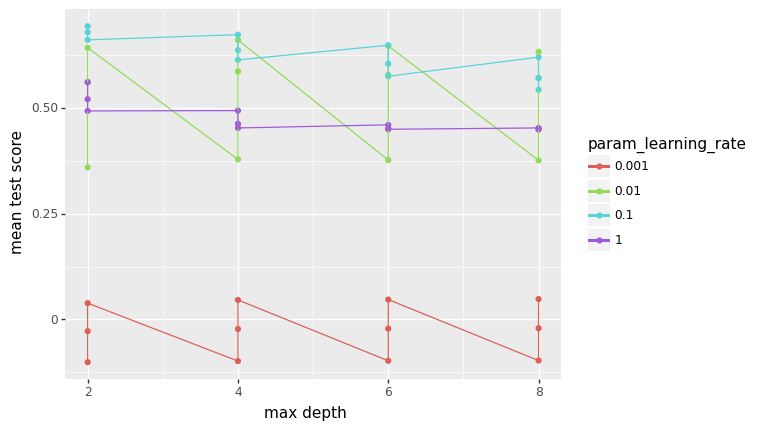

<ggplot: (166676789474)>

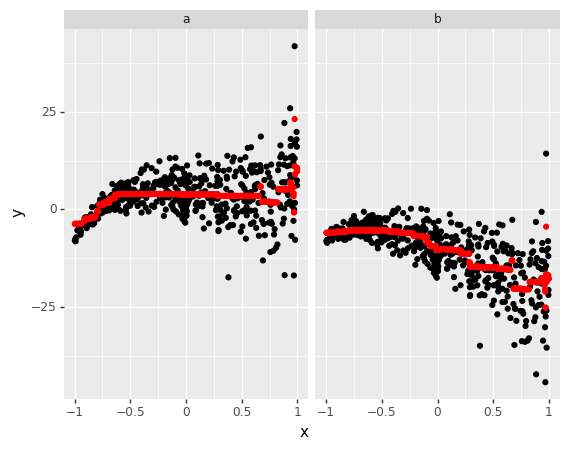

<ggplot: (166676658363)>

In [54]:
xgb_gridsearch = sklearn.model_selection.GridSearchCV(
    xgb_model,
    param_grid = param_grid,
    cv = splitter.split(X_renamed, y, df.cluster)
)

xgb_gridsearch.fit(X_renamed, y)

xgb_cv_perf_df = pd.DataFrame(xgb_gridsearch.cv_results_)
xgb_cv_perf_df.param_max_depth = xgb_cv_perf_df.param_max_depth.astype('int')

(
    pn.ggplot(xgb_cv_perf_df,
                pn.aes(x = 'param_max_depth',
                            y = 'mean_test_score',
                            color = 'param_learning_rate'
                            )
    )
    + pn.geom_point()
    + pn.geom_line()
    + pn.labs(x = 'max depth', y = 'mean test score')
)

xgb_best = xgb_gridsearch.best_estimator_
xgb_best_predictions = xgb_best.predict(X_renamed)
df = df.assign(xgb_best_predictions = xgb_best_predictions)

(
    pn.ggplot(df,
                pn.aes(x = 'x',
                            y = 'y'
                            )
    )
    + pn.geom_point(color = 'black')
    + pn.geom_point(pn.aes(y = 'xgb_best_predictions'), color = 'red')
    + pn.facet_wrap('~ obstype')
)



## 8.c Interpret the best-performing `xgboost` model

The best-performing model can be extracted with `xgb_best = xgb_gridsearch.best_estimator_`. Obtain its predictions with `.predict(X_renamed)` and store them as a new column in `df` named `xgb_best_predictions`.

Next, extract `.feature_importances_` from `xgb_best` and present it in a sensible form. Interpret the results, which represent a weighted combination of how often a feature is used as a tree splitting point and the predictive gain resulting from that split.

Then, several component trees and compare them to those obtained with default settings. 

Plot the raw data and overlay the best conditional expectation function estimated with `xgboost` in blue. Overlay the best conditional expectation function from a decision tree in red. Compare the results.

Finally, use the `.score()` method to compute the $R^2$, or proportion of variance explained, for (i) the best decision tree and (ii) the best `xgboost` model. Compare to the $R^2$ previously obtained with a correctly specified OLS model and describe the advantages and disadvantages of the tree models.

array([0.8939819 , 0.        , 0.10601816], dtype=float32)

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

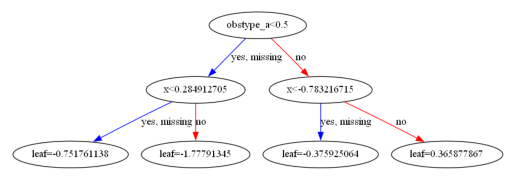

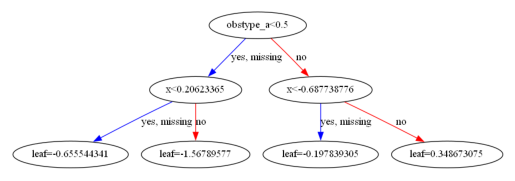

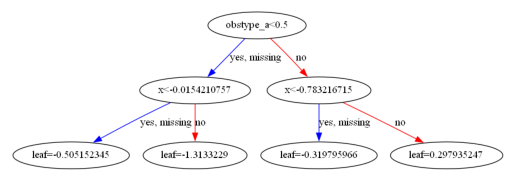

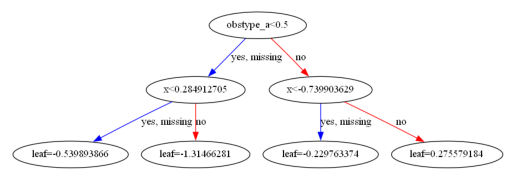

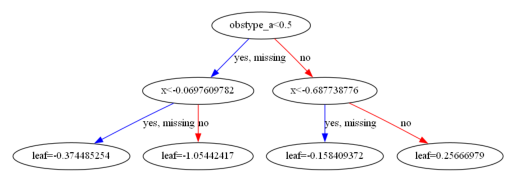

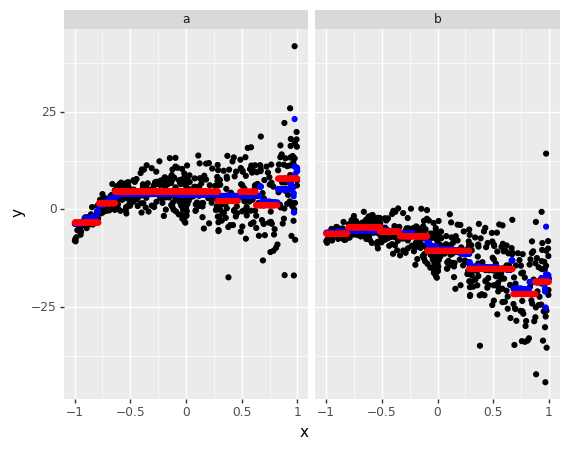

<ggplot: (166676697914)>

0.724014790354002

0.7554574289505365

In [55]:

xgb_best = xgb_gridsearch.best_estimator_
xgb_best_predictions = xgb_best.predict(X_renamed)
df = df.assign(xgb_best_predictions = xgb_best_predictions)

xgb_best.feature_importances_

xgb.plot_tree(xgb_best, num_trees = 0)
xgb.plot_tree(xgb_best, num_trees = 1)
xgb.plot_tree(xgb_best, num_trees = 2)
xgb.plot_tree(xgb_best, num_trees = 3)
xgb.plot_tree(xgb_best, num_trees = 4)

(
    pn.ggplot(df,
                pn.aes(x = 'x',
                            y = 'y'
                            )
    )
    + pn.geom_point(color = 'black')
    + pn.geom_point(pn.aes(y = 'xgb_best_predictions'), color = 'blue')
    + pn.geom_point(pn.aes(y = 'tree_best_predictions'), color = 'red')
    + pn.facet_wrap('~ obstype')
)

tree_best.score(X, y)
xgb_best.score(X_renamed, y)


